## Imports

In [1]:
import numpy as np
from qiskit import *
from qiskit.transpiler import PassManager, preset_passmanagers
from qiskit.transpiler.passes.optimization import TemplateOptimization, Collect2qBlocks, CollectMultiQBlocks
from qiskit.transpiler.passes.optimization.template_matching import *
from qiskit.converters import circuit_to_dag, circuit_to_dagdependency, dagdependency_to_circuit, dagdependency_to_dag
from qiskit.visualization import dag_drawer
from qiskit.quantum_info import Operator
import os
from qiskit import QuantumCircuit


## Create template list

In [2]:
templates = []
dir = "/Users/christiangrauberger/Library/CloudStorage/OneDrive-Personal/Research/ThreeQBReducedMatches"

for file in os.listdir(dir):
    filename = os.fsdecode(file)
    if filename.endswith('.txt'):
        file_path = os.path.join(dir, filename)
        templates.append(QuantumCircuit.from_qasm_file(file_path))


## 3-qubit proof of concept

### Create original circuit and template-matched circuit

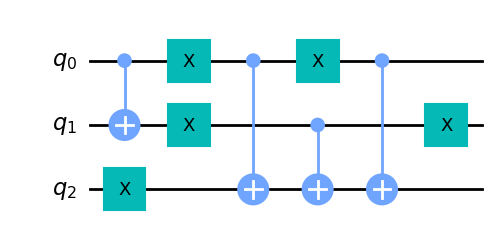

In [3]:
circ1 = QuantumCircuit(3)

circ1.cx(0, 1)
circ1.x(2)

circ1.x(0)
circ1.x(1)

circ1.cx(0, 2)

circ1.x(0)

circ1.cx(1, 2)

circ1.cx(0, 2)
circ1.x(1)

circ1.draw('mpl')

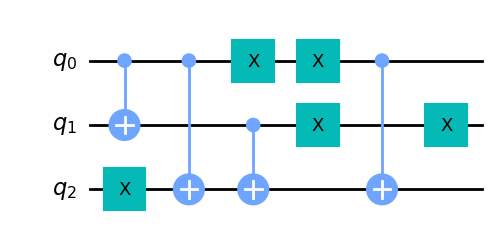

In [4]:
commuted_circ = QuantumCircuit(3)

commuted_circ.cx(0, 1)
commuted_circ.x(2)

commuted_circ.cx(0, 2)

commuted_circ.x(0)
commuted_circ.cx(1, 2)

commuted_circ.x(0)
commuted_circ.x(1)

commuted_circ.cx(0, 2)
commuted_circ.x(1)

commuted_circ.draw('mpl')


### Optimize original circuit

/Users/christiangrauberger/miniconda3/envs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/christiangrauberger/miniconda3/envs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


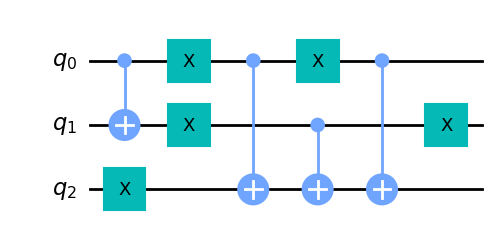

In [5]:
pass_ = TemplateOptimization()
pm = PassManager(pass_)

reduced_circ = transpile(circuits=circ1, optimization_level=3)
reduced_circ.draw('mpl')

### Optimize template-matched circuit

/Users/christiangrauberger/miniconda3/envs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/christiangrauberger/miniconda3/envs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


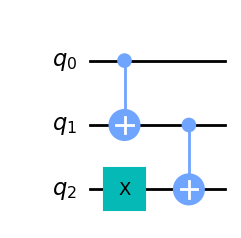

In [6]:
reduced_circ = transpile(circuits=commuted_circ, optimization_level=3)
reduced_circ.draw('mpl')

### Compare matricies

In [7]:
U1 = Operator(circ1)
U2 = Operator(reduced_circ)
display(U1 == U2)

True

## Messing with collect blocks

[[DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1)), cargs=()),
  DAGOpNode(op=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 1),), cargs=()),
  DAGOpNode(op=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 0),), cargs=())],
 [DAGOpNode(op=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 2),), cargs=()),
  DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 2)), cargs=()),
  DAGOpNode(op=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 0),), cargs=())],
 [DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumReg

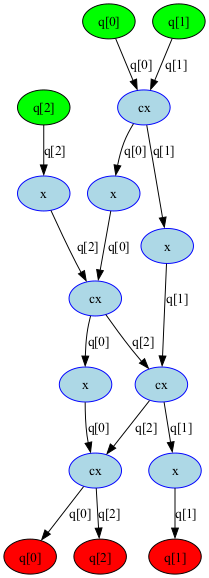

In [8]:
dag = circuit_to_dag(circ1)
block_collector = Collect2qBlocks()
block_collector.run(dag=dag)
block_list = block_collector.property_set["block_list"]
display(block_list)
dag_drawer(dag)



### Testing CollectMultiQBlocks with a circuit

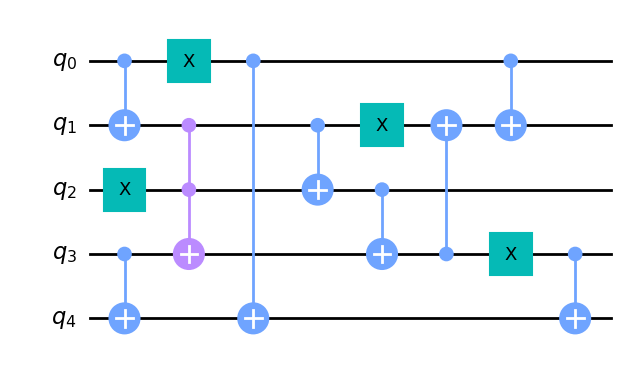

In [9]:
circ2 = QuantumCircuit(5)

circ2.cx(0, 1)
circ2.x(2)
circ2.cx(3, 4)

circ2.x(0)
circ2.ccx(1, 2, 3)

circ2.cx(0, 4)

circ2.cx(1, 2)

circ2.x(1)
circ2.cx(2, 3)

circ2.cx(3, 1)

circ2.cx(0, 1)
circ2.x(3)

circ2.cx(3, 4)
circ2.draw('mpl')

In [10]:
def Collect3qBlocks(dag):
    _collector = CollectMultiQBlocks(3)
    _collector.run(dag)

    all_blocks = _collector.property_set["block_list"]
    new_blocks = []

    for block in all_blocks:
        qubits = set()
        for op in block:
            for arg in op.qargs:
                qubits.add(arg.index)
            if len(qubits) == 3:
                new_blocks.append(block)
                break

    return new_blocks

def CollectNqBlocks(dag, N_qubits : int):
    _collector = CollectMultiQBlocks(N_qubits)
    _collector.run(dag)

    all_blocks = _collector.property_set["block_list"]
    new_blocks = []

    for block in all_blocks:
        qubits = set()
        for op in block:
            for arg in op.qargs:
                qubits.add(arg.index)
            if len(qubits) == N_qubits:
                new_blocks.append(block)
                break

    return new_blocks


In [11]:
dag = circuit_to_dag(circ1)

new_blocks = CollectNqBlocks(dag, 3)

for x in new_blocks:
    display(x)

/var/folders/tt/5s0ynggn26lcj4vvlpm6sw4r0000gn/T/ipykernel_75784/3493824821.py:30: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  qubits.add(arg.index)


[DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1)), cargs=()),
 DAGOpNode(op=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 0),), cargs=()),
 DAGOpNode(op=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 1),), cargs=()),
 DAGOpNode(op=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 2),), cargs=()),
 DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 2)), cargs=()),
 DAGOpNode(op=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 0),), cargs=()),
 DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 

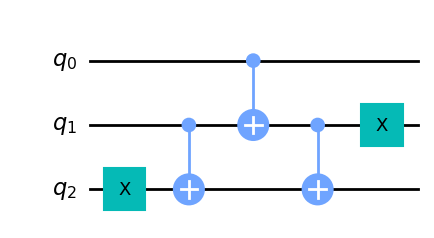

In [12]:
identity = QuantumCircuit(3)

identity.cx(1, 2)
identity.cx(0, 1)
identity.cx(1, 2)
identity.cx(0, 1)
identity.cx(0, 2)

circuit = QuantumCircuit(3)

circuit.x(2)
circuit.cx(1, 2)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.x(1)
circuit.draw('mpl')

[[0, 1], [1, 2], [2, 3]]

ValueError: Could not save to JPEG for display

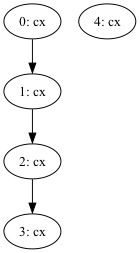

In [13]:
dag_templates = []
dag_templates.append(circuit_to_dagdependency(identity))

dag1 = circuit_to_dagdependency(circuit)

pass_ = TemplateMatching(circuit_dag_dep=dag1, template_dag_dep=dag_templates[0])
pass_.run_template_matching()
matches = pass_.match_list

maximal = MaximalMatches(matches)
maximal.run_maximal_matches()
max_matches = maximal.max_match_list
display(max_matches[0].match)

substitution = TemplateSubstitution(max_matches, pass_.circuit_dag_dep, pass_.template_dag_dep)
substitution.run_dag_opt()
circ_dag_dep = substitution.dag_dep_optimized
circ = dagdependency_to_circuit(circ_dag_dep)
dag_drawer(dag_templates[0])


ValueError: Could not save to JPEG for display

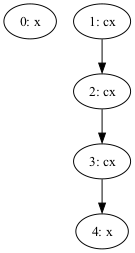

In [ ]:
dag_drawer(dag1)